## Disaster Tweets Classification

### The problem
The social media platform formerly known as Twitter is still being used by some first responders and other workers to broadcast emergency information. It would be helpful to have a machine learning model that could distinguish between tweets about actual emergencies and other tweets that might be using hyperbole to describe relatively mundane occurrences.

### The data
Two sets of tweets, for training and testing a model, supplied by Kaggle as part of a Getting Started competition: https://www.kaggle.com/c/nlp-getting-started/overview

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import random
import re
import requests
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Conv1D
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import pad_sequences

from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I previously downloaded the files that Kaggle provided and stored them to my Google Drive to facilitate Google Colab access.

In [3]:
dfTrain = pd.read_csv("drive/MyDrive/NLP_Tweets/train.csv")
dfTest = pd.read_csv("drive/MyDrive/NLP_Tweets/test.csv")
print("dfTrain shape: ", dfTrain.shape)
print("dfTest shape: ", dfTest.shape)

dfTrain shape:  (7613, 5)
dfTest shape:  (3263, 4)


The extra column in the training set is the answer key for supervised learning.

In [4]:
dfTrain.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
dfTest.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Exploratory Data Analysis
How dirty is this data? Let's start by looking for missing values, out of 7613 total tweets.

In [6]:
missingLocation = dfTrain[dfTrain.location.isnull()]
missingKeyword = dfTrain[dfTrain.keyword.isnull()]
missingText = dfTrain[dfTrain.text.isnull()]

print("Number of missing Location entries: ", len(missingLocation))
print("Number of missing Keyword entries: ", len(missingKeyword))
print("Number of missing Text entries: ", len(missingText))


Number of missing Location entries:  2533
Number of missing Keyword entries:  61
Number of missing Text entries:  0


That's a lot of missing locations! Is there enough overlap between the locations in the training set and the test set to make it worth keeping?

In [7]:
uniqueTrain = dfTrain.location.unique()
uniqueTest = dfTest.location.unique()

# What's the intersection of these two lists?
bothLocations = set(uniqueTrain) & set(uniqueTest)
print("Number of unique locations in training set: ", len(uniqueTrain))
print("Number of locations in both sets: ", len(bothLocations))

Number of unique locations in training set:  3342
Number of locations in both sets:  423


It's hard to imagine the usefulness of the location field given the wide range of unique values and minimal overlap with the test set. Let's remove that column.

In [8]:
dfTrain.drop(columns=['location'], inplace = True)
dfTest.drop(columns=['location'], inplace = True)
dfTrain.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Now let's check on the keywords.

In [9]:
uniqueTrain = dfTrain.keyword.unique()
uniqueTest = dfTest.keyword.unique()

# What's the intersection of these two lists?
bothKeywords = set(uniqueTrain) & set(uniqueTest)
print("Number of unique keywords in training set: ", len(uniqueTrain))
print("Number of keywords in both sets: ", len(bothKeywords))

Number of unique keywords in training set:  222
Number of keywords in both sets:  222


100% overlap suggests that it would be a good idea to keep the keyword column.

The pie chart below shows that there is not a large imbalance between target=0 and target=1 tweets in the testing set, so we can also refrain from removing excess False Alarm tweets.

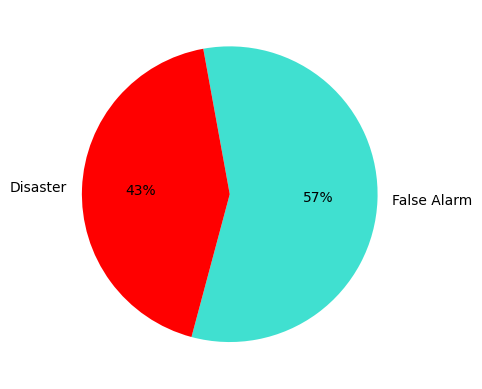

In [10]:
countDisaster = dfTrain['target'].value_counts()
pieLabels = ['False Alarm', 'Disaster']
plt.pie(countDisaster, labels=pieLabels, startangle=255, autopct='%.0f%%', colors=['turquoise', 'red'])
plt.show()

Let's try to clean up some of the trash in these tweets.

In [11]:
def delURL(inTweet):
    cleanURL = re.compile(r'https?://\S+|www\.\S+')
    return cleanURL.sub(r'', inTweet)

def delPun(inTweet):
    noPun = str.maketrans('', '', string.punctuation)
    return inTweet.translate(noPun)

def delStops(inTweet):
  wordList = inTweet.split()
  for eachWord in wordList:
    if eachWord in stopwords.words('english'):
      wordList.remove(eachWord)
  return ' '.join(wordList)

def stringClean(inTweet):
    inTweet = delURL(inTweet)
    inTweet = delPun(inTweet)
    inTweet = delStops(inTweet)

    return inTweet

dfTrain['cleanText'] = dfTrain['text'].apply(lambda inTweet : stringClean(inTweet))
dfTest['cleanText'] = dfTest['text'].apply(lambda inTweet : stringClean(inTweet))

Since we can't test our models against the competition's test set, we'll split off part of the training data and use it to validate those models.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(dfTrain.text, dfTrain.target, test_size = 0.2, random_state = 10)
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

Time to count and tokenize the words to make them easier to process.

In [13]:
wordCounter = Counter()
for eachTweet in dfTrain.text.values:
    wordCounter.update(eachTweet.split())

uniqueWords = len(wordCounter)
print("Unique words in tweet set: ", uniqueWords)
print(wordCounter.most_common(10))


Unique words in tweet set:  31924
[('the', 2575), ('a', 1845), ('to', 1805), ('in', 1757), ('of', 1722), ('and', 1302), ('I', 1197), ('for', 820), ('is', 814), ('on', 773)]


In [14]:
# tensorflow.keras.preprocessing.text.Tokenizer is _Deprecated_,
# but it works perfectly here (for now)
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = uniqueWords)
tokenizer.fit_on_texts(X_train)
trainSequences = tokenizer.texts_to_sequences(X_train)
validSequences = tokenizer.texts_to_sequences(X_val)

In [15]:
maxPad = 26  # We can change this later to see whether it makes a difference
trainPad = pad_sequences(trainSequences, maxlen=maxPad, padding="post", truncating="post")
validPad = pad_sequences(validSequences, maxlen=maxPad, padding="post", truncating="post")

# Print an example to make sure the padding looks right
print(X_train[21])
print(trainSequences[21])
print(trainPad[21])

@JulieChen she shouldn't. Being with them is gonna ruin her game and Vanessa is a great player
[6060, 221, 1501, 121, 16, 108, 11, 337, 307, 79, 338, 9, 6061, 11, 5, 202, 1658]
[6060  221 1501  121   16  108   11  337  307   79  338    9 6061   11
    5  202 1658    0    0    0    0    0    0    0    0    0]


In [16]:
print(trainPad.shape)

(6090, 26)


Let's run those numbers backwords to make sure they match the indexed words.

In [17]:
flipIndex = []
for (eachWord, eachIndex) in tokenizer.word_index.items():
  flipIndex.append((eachIndex, eachWord))

top10String = ""
print(trainSequences[21])
for eachItem in trainSequences[21]:
  # adjusting by one for empty dict start
  top10String = top10String + " " + flipIndex[eachItem-1][1]

print(top10String)

[6060, 221, 1501, 121, 16, 108, 11, 337, 307, 79, 338, 9, 6061, 11, 5, 202, 1658]
 juliechen she shouldn't being with them is gonna ruin her game and vanessa is a great player


### Analysis - Model Building and Training
It's time to create our first model for this data. We'll start with a bidirectional LSTM combined with a stacked LSTM.

In [20]:
biLSTM = Sequential()
biLSTM.add(Embedding(input_dim = uniqueWords, embeddings_initializer = 'uniform', output_dim = 32, mask_zero=False))
biLSTM.add(Bidirectional(LSTM(units = 256, activation = 'tanh', return_sequences = True, dropout = 0.1), weights = None))
biLSTM.add(Bidirectional(LSTM(units = 256, activation = 'tanh', return_sequences = True, dropout = 0.1), weights = None))
biLSTM.add(LSTM(units = 256, activation = 'tanh'))

biLSTM.add(Dropout(rate = 0.3))
biLSTM.add(Dense(units = 32, activation = 'relu', use_bias = True))
biLSTM.add(Dense(units = 1, activation = "sigmoid"))

biLSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile and train the model
biLSTM.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
esCallback = EarlyStopping(patience = 2, restore_best_weights = True)
biResult = biLSTM.fit(x = trainPad, y = y_train, batch_size = 64, epochs = 8, validation_data = (validPad, y_val), callbacks = [esCallback])

Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.6414 - loss: 0.6265 - val_accuracy: 0.7951 - val_loss: 0.4559
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8886 - loss: 0.3076 - val_accuracy: 0.7689 - val_loss: 0.4788
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9392 - loss: 0.1957 - val_accuracy: 0.7728 - val_loss: 0.5584


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.7857 - loss: 0.4620
Loss: 0.4559258818626404
Accuracy: 0.7951411604881287


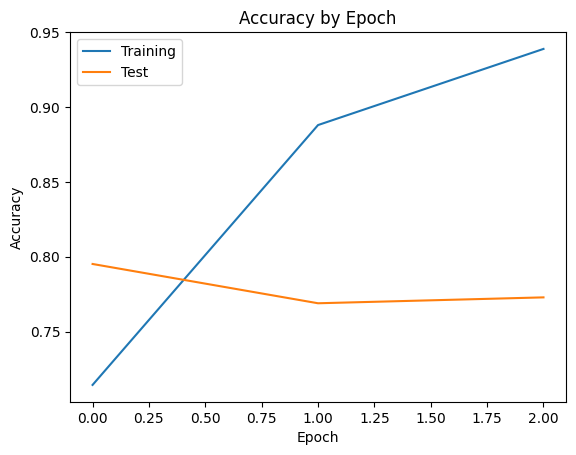

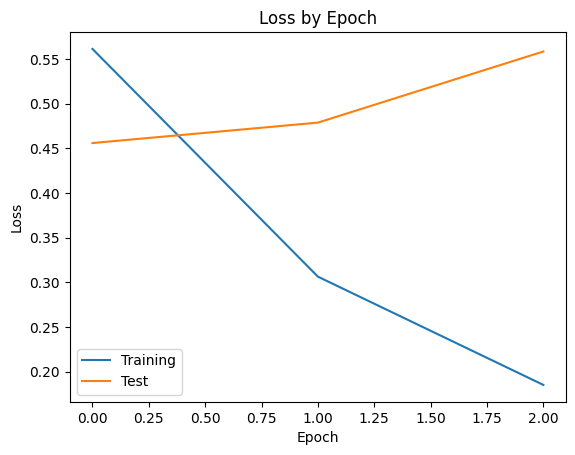

In [22]:
#Plot the results
biLoss, biAcc = biLSTM.evaluate(validPad, y_val)
print('Loss:', biLoss)
print('Accuracy:', biAcc)

plt.plot(biResult.history['accuracy'])
plt.plot(biResult.history['val_accuracy'])
plt.title('Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'])
plt.show()

plt.plot(biResult.history['loss'])
plt.plot(biResult.history['val_loss'])
plt.title('Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='lower left')
plt.show()

Try CNN

In [27]:
cnnModel = Sequential()
cnnModel.add(Embedding(input_dim = uniqueWords, embeddings_initializer = 'uniform', output_dim = 128, mask_zero=False))
cnnModel.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'))
cnnModel.add(MaxPooling1D(pool_size = 2, strides = None))
cnnModel.add(Conv1D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu'))
cnnModel.add(MaxPooling1D(pool_size = 2, strides = None))

cnnModel.add(Flatten())
cnnModel.add(Dense(units = 10, activation = 'relu', use_bias = True))
cnnModel.add(Dropout(rate = 0.3))
cnnModel.add(Dense(units = 1, activation='sigmoid', use_bias = True))
cnnModel.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile and train the CNN model
cnnModel.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
esCallback = EarlyStopping(patience = 2, restore_best_weights = True)
cnnResult = cnnModel.fit(x = trainPad, y = y_train, epochs = 12, batch_size = 32, validation_data = (validPad, y_val), callbacks = [esCallback])

Epoch 1/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.5902 - loss: 0.6568 - val_accuracy: 0.7840 - val_loss: 0.4901
Epoch 2/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.8587 - loss: 0.3811 - val_accuracy: 0.7879 - val_loss: 0.4802
Epoch 3/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9444 - loss: 0.2154 - val_accuracy: 0.7879 - val_loss: 0.6431
Epoch 4/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9819 - loss: 0.1245 - val_accuracy: 0.7761 - val_loss: 0.7560


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7817 - loss: 0.4855
Loss: 0.48023614287376404
Accuracy: 0.7879185676574707


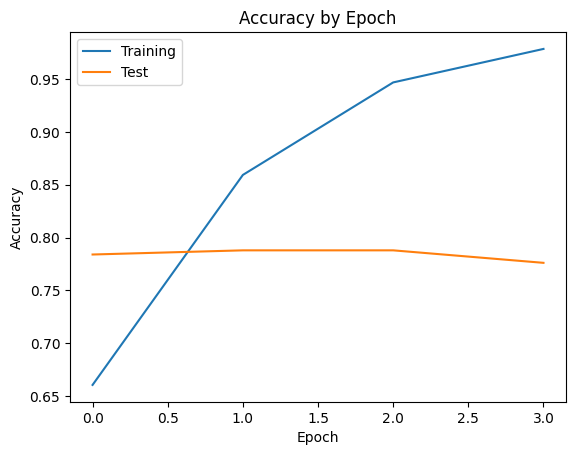

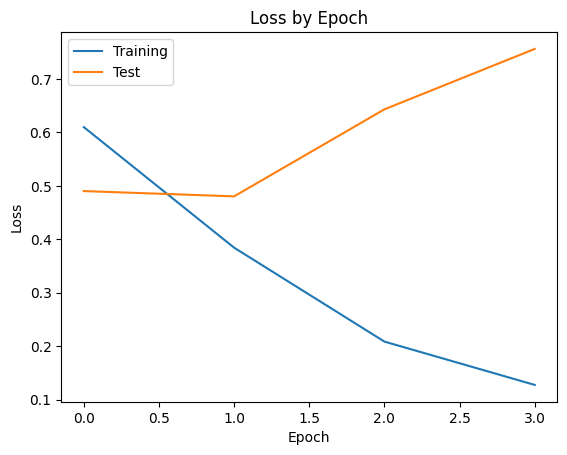

In [29]:
#Plot the results
cnnLoss, cnnAcc = cnnModel.evaluate(validPad, y_val)
print('Loss:', cnnLoss)
print('Accuracy:', cnnAcc)

plt.plot(cnnResult.history['accuracy'])
plt.plot(cnnResult.history['val_accuracy'])
plt.title('Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'])
plt.show()

plt.plot(cnnResult.history['loss'])
plt.plot(cnnResult.history['val_loss'])
plt.title('Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'])
plt.show()

The instructions implied that we should try giving our models a little GloVe.

In [30]:
import gensim.downloader

gloveModel = gensim.downloader.load("glove-wiki-gigaword-100")
embMatrix = np.zeros((uniqueWords, gloveModel.vector_size))
for word, wIndex in tokenizer.word_index.items():
  if uniqueWords >= wIndex:
    try:
      embVector = gloveModel[word]
      embMatrix[wIndex] = embVector
    except KeyError:
      pass

[==================================================] 100.0% 128.1/128.1MB downloaded


In [34]:
rnnGModel = Sequential()
rnnGModel.add(Embedding(input_dim = uniqueWords, output_dim = gloveModel.vector_size, weights = [embMatrix]))
rnnGModel.add(Bidirectional(LSTM(units = 256, activation = 'tanh', return_sequences = True, dropout=0.1), weights = None))
rnnGModel.add(BatchNormalization(momentum = 0.99, center = True, scale = True))
rnnGModel.add(Bidirectional(LSTM(units = 256, activation = 'tanh', return_sequences = True, dropout=0.1), weights = None))
rnnGModel.add(BatchNormalization(momentum = 0.99, center = True, scale = True))
rnnGModel.add(LSTM(units = 256, activation = 'tanh'))
rnnGModel.add(BatchNormalization(momentum = 0.99, center = True, scale = True))
rnnGModel.add(Dropout(rate = 0.3))
rnnGModel.add(Dense(units = 32, activation = 'relu', use_bias = True))
rnnGModel.add(Dense(units = 1, activation = "sigmoid"))

rnnGModel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │       3,192,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,192,400 (12.18 MB)

 Trainable params: 3,192,400 (12.18 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile and train the model
rnnGModel.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
esCallback = EarlyStopping(patience = 2, restore_best_weights = True)
rnnGResult = rnnGModel.fit(x = trainPad, y = y_train, epochs = 12, batch_size = 32, validation_data = (validPad, y_val), callbacks = [esCallback])

Epoch 1/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 187s 907ms/step - accuracy: 0.7199 - loss: 0.5992 - val_accuracy: 0.7183 - val_loss: 0.5516
Epoch 2/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 202s 908ms/step - accuracy: 0.7918 - loss: 0.4563 - val_accuracy: 0.7912 - val_loss: 0.4861
Epoch 3/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 198s 889ms/step - accuracy: 0.8210 - loss: 0.4118 - val_accuracy: 0.7800 - val_loss: 0.4466
Epoch 4/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 203s 897ms/step - accuracy: 0.8614 - loss: 0.3438 - val_accuracy: 0.8135 - val_loss: 0.4360
Epoch 5/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 204s 908ms/step - accuracy: 0.9020 - loss: 0.2586 - val_accuracy: 0.7649 - val_loss: 0.7093
Epoch 6/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 201s 905ms/step - accuracy: 0.9190 - loss: 0.2173 - val_accuracy: 0.7853 - val_loss: 0.6237


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.8085 - loss: 0.4380
Loss: 0.43600061535835266
Accuracy: 0.813525915145874


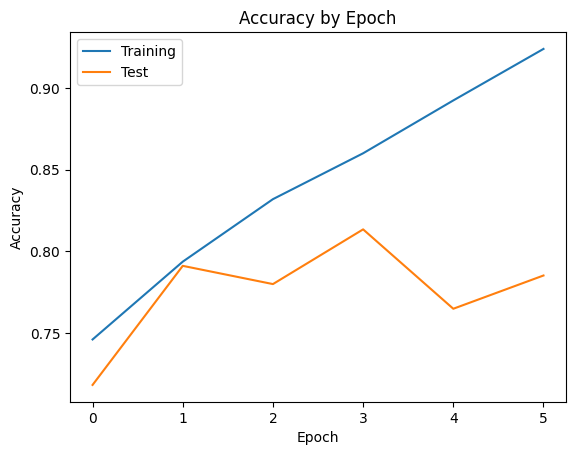

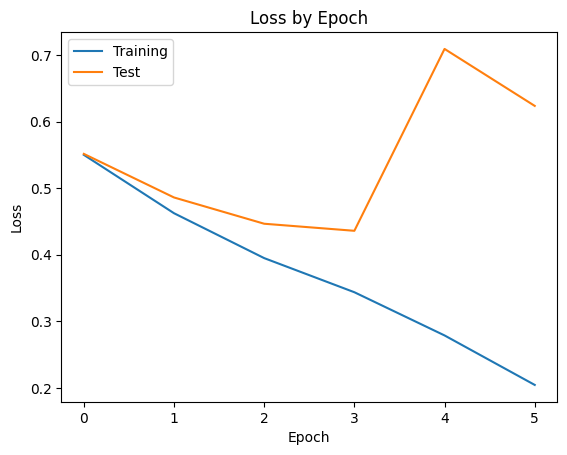

In [36]:
#Plot the results
rnnGLoss, rnnGAcc = rnnGModel.evaluate(validPad, y_val)
print('Loss:', rnnGLoss)
print('Accuracy:', rnnGAcc)

plt.plot(rnnGResult.history['accuracy'])
plt.plot(rnnGResult.history['val_accuracy'])
plt.title('Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'])
plt.show()

plt.plot(rnnGResult.history['loss'])
plt.plot(rnnGResult.history['val_loss'])
plt.title('Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'])
plt.show()

In [39]:
# CNN model with GloVe embeddings
cnnGModel = Sequential()
cnnGModel.add(Embedding(input_dim = uniqueWords, output_dim = gloveModel.vector_size, weights = [embMatrix]))
cnnGModel.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'))
cnnGModel.add(MaxPooling1D(pool_size = 2, strides = None))
cnnGModel.add(BatchNormalization())
cnnGModel.add(Conv1D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu'))
cnnGModel.add(MaxPooling1D(pool_size = 2, strides = None))
cnnGModel.add(BatchNormalization())

cnnGModel.add(Flatten())
cnnGModel.add(Dense(units = 128, activation = 'relu', use_bias = True))
cnnGModel.add(Dropout(rate = 0.45))
cnnGModel.add(Dense(units = 1, activation = 'sigmoid', use_bias = True))
cnnGModel.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │       3,192,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,192,400 (12.18 MB)

 Trainable params: 3,192,400 (12.18 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile and train the model
cnnGModel.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
esCallback = EarlyStopping(patience = 2, restore_best_weights = True)
cnnGResult = cnnGModel.fit(x = trainPad, y = y_train, epochs = 12, batch_size = 64, validation_data = (validPad, y_val), callbacks = [esCallback])

Epoch 1/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.6807 - loss: 0.6816 - val_accuracy: 0.7741 - val_loss: 0.5161
Epoch 2/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8448 - loss: 0.3712 - val_accuracy: 0.7892 - val_loss: 0.4670
Epoch 3/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8845 - loss: 0.2795 - val_accuracy: 0.7610 - val_loss: 0.5898
Epoch 4/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9217 - loss: 0.1962 - val_accuracy: 0.7859 - val_loss: 0.5248


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7872 - loss: 0.4688
Loss: 0.4670379161834717
Accuracy: 0.7892317771911621


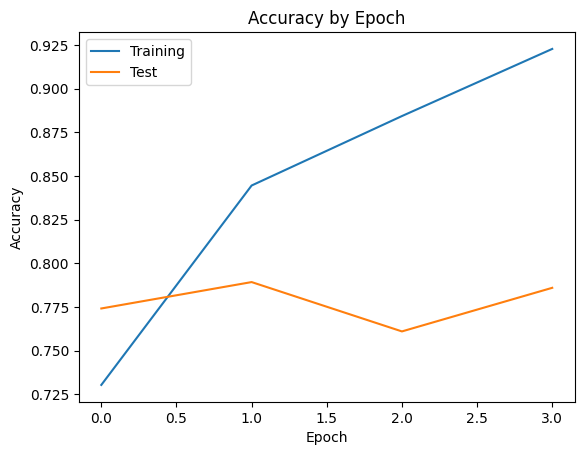

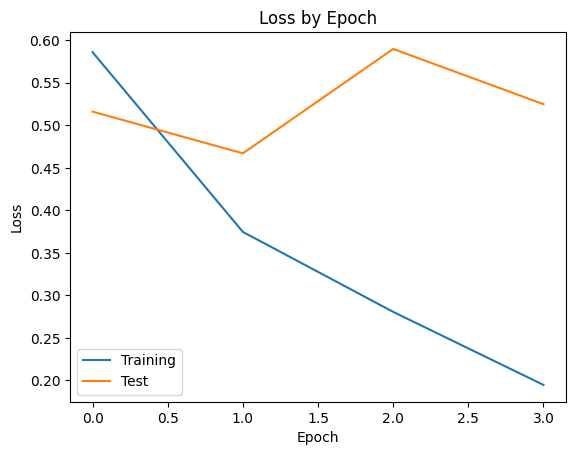

In [41]:
# Plot the results
cnnGLoss, cnnGAcc = cnnGModel.evaluate(validPad, y_val)
print('Loss:', cnnGLoss)
print('Accuracy:', cnnGAcc)

plt.plot(cnnGResult.history['accuracy'])
plt.plot(cnnGResult.history['val_accuracy'])
plt.title('Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'])
plt.show()

# Plot the training and validation loss
plt.plot(cnnGResult.history['loss'])
plt.plot(cnnGResult.history['val_loss'])
plt.title('Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'])
plt.show()

What about XGBoost? Since we need to use *something* to create our submission, we'll use that.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

tVectorizer = TfidfVectorizer()
tVectTrain = tVectorizer.fit_transform(X_train)
tVectValid = tVectorizer.transform(X_val)

xgbClass = XGBClassifier()
xgbClass.fit(tVectTrain, y_train)
predArray = xgbClass.predict(tVectValid)
print(classification_report(y_val, predArray))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       861
           1       0.81      0.64      0.71       662

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.76      1523
weighted avg       0.78      0.78      0.77      1523



Remember that original test.csv file? It's finally time to use it to create our competition submission.

In [46]:
# Clean the text a bit before we vectorize it
dfTest['text'] = dfTest['text'].map(delURL)
dfTest['text'] = dfTest['text'].map(delPun)
dfTest['text'] = dfTest['text'].map(delStops)

finalXTest = tVectorizer.transform(dfTest['text'])
finalPredArray = xgbClass.predict(finalXTest)

compSub = pd.DataFrame({'id': dfTest['id'], 'target': finalPredArray})
compSub.to_csv('tweetCompSub.csv', index = False)

In [47]:
!cp tweetCompSub.csv "drive/MyDrive/NLP_Tweets/"

### Results
As you can see above, I tried several models with and without GloVe. Let's graph their accuracy with the validation data.

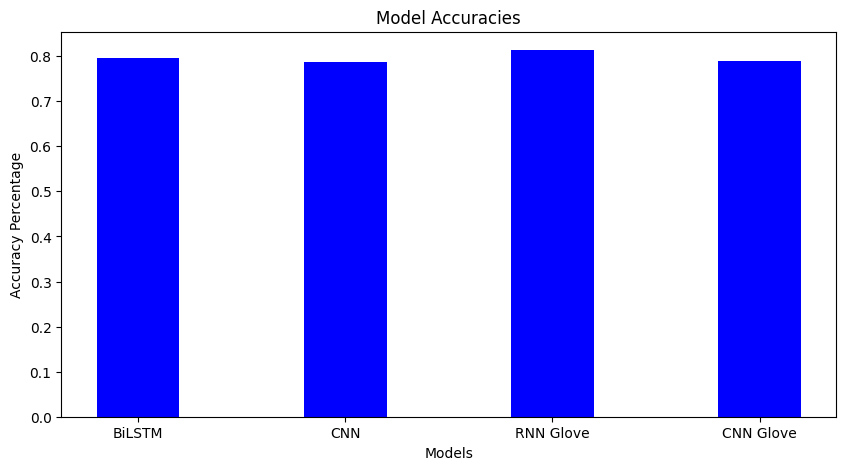

In [50]:
data = {'BiLSTM':biAcc,
        'CNN':cnnAcc,
        'RNN Glove':rnnGAcc,
        'CNN Glove':cnnGAcc}
models = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(models, values, color = 'blue', width = 0.4)
plt.xlabel("Models")
plt.ylabel("Accuracy Percentage")
plt.title("Model Accuracies")
plt.show()

### Conclusion
The RNN model with GloVe had the highest accuracy with the vaidation dataset.

The instructions for this class assignment mentioned that we should not spend a lot of time trying different parameters to improve model performance. I feel confident that others can improve on these scores by just a bit of parameter tweaking.